# Exercise

file name: discrete_anomaly_detection.py or discrete_anomaly_detection.ipynb

Discrete Data + Probability

- Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [29]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [30]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [31]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [33]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [34]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [35]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [36]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [37]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
4,68.201.219.223,21,0.001502
5,24.26.242.9,21,0.001502
6,70.121.214.34,2,0.000143
7,35.175.171.137,2,0.000143
8,52.87.230.102,2,0.000143
9,52.90.165.200,1,0.000072
10,3.88.129.158,1,0.000072
11,3.92.201.136,1,0.000072
12,54.172.14.223,1,0.000072
13,95.31.18.119,1,0.000072


22
               ip  ip_count  ip_proba
12  54.172.14.223         1  0.000072
13   95.31.18.119         1  0.000072
14  34.229.70.250         1  0.000072
15   35.174.209.2         1  0.000072
16   52.91.30.150         1  0.000072
17  34.207.64.242         1  0.000072
18  97.105.15.120         1  0.000072
19   45.23.250.16         1  0.000072
20   95.31.16.121         1  0.000072
21  54.145.52.184         1  0.000072


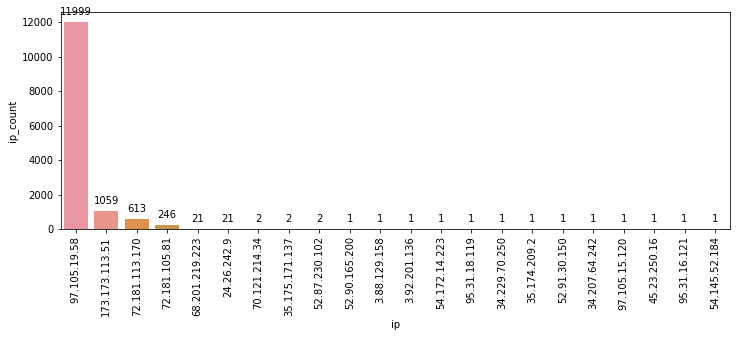

In [38]:
print(len(ip_df))

print(ip_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

In [41]:
df['2019-04-16 19:34:42':'2019-04-17 12:55:14']

TypeError: Cannot compare tz-naive and tz-aware datetime-like objects